# Path Visualizer

## What is this?

This notebook accomplishes the following:
1) **Downloading** and **formatting** data in a form usable by the **Parallang Simulator**.
2) **Visualization** of the true shortest route between **any two points** on the graph.
3) **Reading** and **visualization** of the output of the **Parallang Simulator** for comparison.

## How do I start?

Begin by **installing and importing the below modules**. Then, read the instructions in each section carefully to find what needs to be changed.

In [1]:
!pip3 install matplotlib
!pip3 install osmnx

     |████████████████████████████████| 9.2 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 139.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 4.8 kB/s  eta 0:00:01
     |████████████████████████████████| 4.7 MB 26 kB/s s eta 0:00:01
     |████████████████████████████████| 301 kB 34.9 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 104 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.5 MB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 36.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 28 kB/s s eta 0:00:01
     |████████████████████████████████| 12.4 MB 33 kB/s s eta 0:00:01
     |██

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import os
import pprint
import random

from collections import defaultdict

## Section 1: Downloading of Data

Set the below variables and run the rest of the blocks in this section before continuing.

In [12]:
# CONSTANTS: Useful if you need something specific.
SOUTHERN_ENGLAND = ['Bristol, UK', 'Cornwall, UK', 'Devon, UK', 'Dorset, UK', 'Gloucestershire, UK', 'Somerset, UK', 'Wiltshire, UK', 'Berkshire, UK', 'Buckinghamshire, UK', 'West Sussex, UK', 'East Sussex, UK', 'Kent, UK', 'Oxfordshire, UK', 'Hampshire, UK', 'Isle of Wight, UK', 'Surrey, UK', 'City of London, UK', 'Greater London, UK', 'Bedfordshire, UK', 'Cambridgeshire, UK', 'Hertfordshire, UK', 'Essex, UK', 'Norfolk, UK', 'Suffolk, UK']


# CHANGE ME: Location to get data from.

place_name = "Gloucestershire, UK"

# Optional (not recommended to change): Change me if you want a different type of graph. Defaultly just paths you can drive.
mode = None

# Optional: It's a whitelist filter that filters out unwanted edges. For large queries, consider implementing a motorway filter
# All others: custom_filter = '["highway"~"primary|primary_link|secondary|secondary_link|tertiary|tertiary_link"]'
# Southern England: '["highway"~"motorway"]'
# Sizes (post-compression):
#    * Southern England (1351) <- 29795 (originally)
#    * Gloucestershire (991)   <- 17941
#    * Bristol (762)           <-  8479
#    * Southampton (455)       <-  7188
#    * Cheltenham (267)        <-  3941
#    * Stroud (110)            <-  3570
#    * Bishop's Cleeve (50)    <-   489

# Unused:
#    Gloucester (227)
#    Bath (97)
#    Andoversford (5)
custom_filter = '["highway"~"primary|primary_link|secondary|secondary_link|tertiary|tertiary_link"]'

# Optional: Change me if you want a directed graph
directed = False

# Optional: Whether to apply graph compression
apply_graph_compression = True & (not directed)

# Optional: Whether to truncate
truncate_to = 400

# Optional: Number of datasets to generate
num_datasets = 20

# CHANGE ME: Location to store edge list in.
filename = f"analyzed_datasets/{place_name}"

# Optional: Whether to output verbosely.
ox.settings.log_console = True

In [8]:
# must set simplify to false, otherwise the simplification ratios of this technique will be terrible!
graph = ox.graph_from_place(place_name, network_type=mode, simplify=False, custom_filter=custom_filter)
if not directed:
    graph = ox.utils_graph.get_undirected(graph)

nodes, edges = ox.graph_to_gdfs(graph)

print("Graph downloaded.")

Graph downloaded.


In [13]:
translations = {}
nextid = 0

shortest_direct_distances = {}

# length is in meters
lengths = edges[["osmid", "length"]]

print("Formatting graph...")
for u, u_keyed_df in lengths.groupby(level=0):
    for v, uv_keyed_df in u_keyed_df.groupby(level=1):
        if u not in translations:
            translations[u] = nextid
            nextid += 1
        if v not in translations:
            translations[v] = nextid
            nextid += 1

        for length in uv_keyed_df["length"]:
            shortest_direct_distances[(translations[u], translations[v])] = min(int(length*1000), shortest_direct_distances.get((u, v), float("inf")))
            if not directed:
                shortest_direct_distances[(translations[v], translations[u])] = shortest_direct_distances[(translations[u], translations[v])]
inverted_translations = {v: k for (k, v) in translations.items()}

two_valency_nodes = set()
if apply_graph_compression:
    print("Beginning compression...")
    edge_list_dict = defaultdict(set)
    for ((e1, e2), d) in shortest_direct_distances.items():
        if e1 == e2: continue
        edge_list_dict[e1].add(e2)
        edge_list_dict[e2].add(e1)
    edge_list_dict = {k: list(v) for (k, v) in edge_list_dict.items()}

    # first, find the two valency nodes
    for n in edge_list_dict:
        if len(edge_list_dict[n]) == 2:
            two_valency_nodes.add(n)

    print(f"Found {len(two_valency_nodes)} two valency nodes, finding paths...")
    collapsed_paths = []
    i = 0
    visited = set()
    for n in two_valency_nodes:
        if n in visited:
            continue

        left_search = []
        right_search = []
        
        left_search = [n, edge_list_dict[n][0]]
        right_search = [edge_list_dict[n][1]]

        visited.add(n)

        for search in [left_search, right_search]:
            if not search: 
                continue
            while search[-1] in two_valency_nodes and any(k not in visited for k in edge_list_dict[search[-1]]):
                visited.add(search[-1])
                k = edge_list_dict[search[-1]][0] 
                if k in visited:
                    k = edge_list_dict[search[-1]][1]
                
                search.append(k)
        collapsed_paths.append((list(reversed(right_search)) + left_search)[1:-1])

    print(f"Collapsed to {len(collapsed_paths)} paths, compressing them...")
    better_egress = {}
    path_length = {}
    node_to_path_id = {}
    collapsed_paths_dict = {}
    egresses_to_path_id = defaultdict(list)
    path_id_to_egresses = {}
    path_id = 0
    for p in collapsed_paths:
        # # don't resolve stand-alone cycles
        # if edge_list_dict[p[-1]] in edge_list_dict[p[0]]:
        #     continue
        
        collapsed_paths_dict[path_id] = p
        k = edge_list_dict[p[0]][0]
        if k in visited: 
            k = edge_list_dict[p[0]][1]
        j = edge_list_dict[p[-1]][0]
        # some paths will be one node.
        # in such a scenario, you need to 
        # ensure differing endpoints are used
        # as p[-1] and p[0] will be the same
        # and hence the len(p) == 1 check
        if j in visited or len(p) == 1:
            j = edge_list_dict[p[-1]][1]

        egresses_to_path_id[(k, j)].append(path_id)
        path_id_to_egresses[path_id] = (k, j)
        
        for n in p:
            node_to_path_id[n] = path_id

        length = sum(shortest_direct_distances[(a, b)] for (a, b) in zip(p[:-1], p[1:]))
        right_escape = length + shortest_direct_distances[(p[-1], j)]
        left_escape = shortest_direct_distances[(k, p[0])]
        for (a, b) in zip(p[:-1], p[1:]):
            if left_escape < right_escape:
                better_egress[a] = (k, left_escape)
            else:
                better_egress[a] = (j, right_escape)
            left_escape += shortest_direct_distances[(a, b)]
            right_escape -= shortest_direct_distances[(a, b)]
        if left_escape < right_escape:
            better_egress[p[-1]] = (k, left_escape)
        else:
            better_egress[p[-1]] = (j, right_escape)
        shortest_direct_distances[(k, j)] = shortest_direct_distances[(j, k)] = min(shortest_direct_distances.get((k, j), float("inf")), right_escape + left_escape)
        path_length[path_id] = right_escape + left_escape
        path_id += 1

    print(f"Shuffling down vertex numbers to account for removed nodes...")
    compressed_shortest_direct_distances = {}
    compressed_translations = {}
    inverted_compressed_translations = {}
    node_id = 0
    for ((e1, e2), d) in shortest_direct_distances.items():
        if e1 in visited or e2 in visited:
            continue
        for e in (e1, e2):
            if e not in inverted_compressed_translations:
                compressed_translations[node_id] = e
                inverted_compressed_translations[e] = node_id
                node_id += 1
        e1_new = inverted_compressed_translations[e1]
        e2_new = inverted_compressed_translations[e2]
        compressed_shortest_direct_distances[(e1_new, e2_new)] = d
        compressed_shortest_direct_distances[(e2_new, e1_new)] = d

dist_to_use = shortest_direct_distances if not apply_graph_compression else compressed_shortest_direct_distances

max_node_num = max(max(shortest_direct_distances, key=lambda t: max(t)))
max_node_num_compressed = max_node_num
if apply_graph_compression:
    max_node_num_compressed = max(max(compressed_shortest_direct_distances, key=lambda t: max(t)))

for i in range(num_datasets):
    old_dist_to_use = dist_to_use
    if max_node_num_compressed > truncate_to:
        print(f"Going to truncate graph to {truncate_to}, currently {max_node_num_compressed+1} nodes")
        all_edges = (list(dist_to_use.items()) + list(((y, x), d) for ((x, y), d) in dist_to_use.items()))
        random.shuffle(all_edges)
        edge = random.choice(all_edges)
        nodes = set((edge[0][0], edge[0][1]))
        while len(nodes) < truncate_to:
            for ((v1, v2), dist) in all_edges:
                if v1 in nodes:
                    nodes.add(v2)
                if len(nodes) >= truncate_to:
                    break
        mappings = {v: i for (i, v) in enumerate(nodes)}
        dist_to_use = {(mappings[v1], mappings[v2]) : d for ((v1, v2), d) in dist_to_use.items() if v1 in nodes and v2 in nodes}
        print("Dropped", len(all_edges) - len(dist_to_use), "edges")

    filename = f"analyzed_datasets/dup_datasets/{truncate_to}/{place_name}Trunc{truncate_to}_{i}.points"
    with open(filename, "w+") as F:
        drops = 0
        for i, (k, v) in enumerate(dist_to_use.items()):
            F.write(f"{i} {k[0]} {k[1]} {v}\n")
    dist_to_use = old_dist_to_use
print(f"The graph has been saved to {os.path.join(os.getcwd(), filename)}") 
if apply_graph_compression:
    # max_node_num_compressed = max(max(compressed_shortest_direct_distances, key=lambda t: max(t)))
    # max_node_num = max(max(shortest_direct_distances, key=lambda t: max(t)))
    node_compression_factor = round((max_node_num_compressed+1)/(max_node_num+1) * 100, 2)
    edge_compression_factor = round(len(compressed_shortest_direct_distances)/len(shortest_direct_distances)*100, 2)
    print(f"Graph edge compression factor: {edge_compression_factor}%")
    print(f"Graph node compression factor: {node_compression_factor}%")
    print(f"Final graph size: {min(max_node_num_compressed, truncate_to)}. Originally: {max_node_num}")

Formatting graph...
Beginning compression...
Found 16946 two valency nodes, finding paths...
Collapsed to 1177 paths, compressing them...
Shuffling down vertex numbers to account for removed nodes...
Going to truncate graph to 400, currently 996 nodes
Dropped 4368 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4332 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4351 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4349 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4318 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4374 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4384 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4324 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4366 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4378 edges
Going to truncate graph to 400, currently 996 nodes
Dropped 4376 edges
Going to truncate g

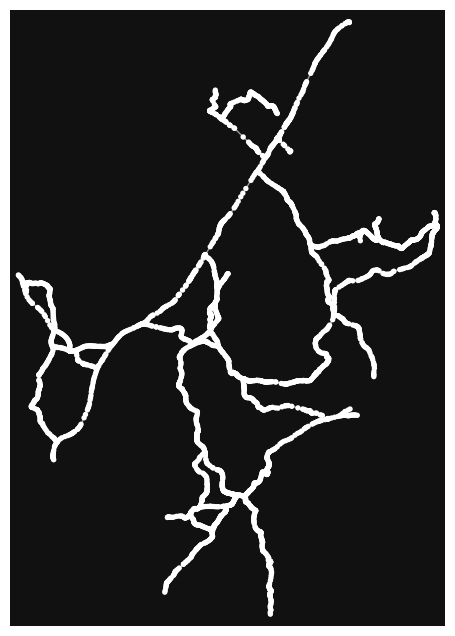

Visualization of Stroud, UK


In [198]:
fig, ax = ox.plot_graph(graph)
print(f"Visualization of {place_name}")

## Section 2: Loading Simulator Output

Before progressing to this section, **run the simulator** on the .points file produced in the previous step. 

It can be read with the `EdgesReader` API.

```scala
val (numNodes, edgeList) = EdgesReader.readEdges("Truckee")oints")
```

Thesuccessorredecessor matrix** from the simulator can be dumped with the MatrixDumper API.

```scSla    
val P = InterconnectionNetwork.recvAsExternal((0, 0), ArrayType(ArrayType(IntTSpe())))
val Pmatr = ArrayValue.matriSToScalaArray(P.v.asInstanceOf[ArrayValue])
Matrsuccessormp("preSecessor.txt", Pmatr)
```

In [259]:
# CHANGE ME: Path to successor/predecessor matrix.
path_to_matrix = "successor.txt"
path_to_distance_matrix = "distances.txt"

# CHANGE ME: Choose either the successor method or predecessor method depending on the underlying algorithm
SUCCESSOR = "successor"
PREDECESSOR = "predecessor"
method = SUCCESSOR

In [247]:
def parseMatrix(filepath: str, local_id_to_global_id=None, do_optimization=True):
    with open(filepath, "r") as F:
        lines = F.readlines()
    lines = map(lambda a: map(int, a), map(lambda s: s.split(" "), lines))
    output = []
    for i, l in enumerate(lines):
        if do_optimization and i not in local_id_to_global_id:
            continue
        translated_line = []
        for e in l:
            if do_optimization and e not in local_id_to_global_id:
                continue
            translated_line.append(e)
        output.append(translated_line)

    return output

def safe_localize(node_l):
    """
    safely resolves a global ID to a local one with graph compression
    """
    if apply_graph_compression:
        node_l = inverted_compressed_translations[node_l]
    return node_l

def path_from_successor(successor, start_l, fin_l):
    start_l = safe_localize(start_l)
    fin_l = safe_localize(fin_l)

    output = [start_l]
    prev_l = fin_l
    while successor[output[-1]][fin_l] != fin_l:
        if successor[output[-1]][fin_l] == output[-1]:
            return []
        output.append(successor[output[-1]][fin_l])
    output.append(fin_l)

    return list(map(lambda e: compressed_translations[e],  output))
    # return list(map(lambda e: l2g_ids[e], output))

def path_from_predecessor(predecessor, start_l, fin_l):
    start_l = safe_localize(start_l)
    fin_l = safe_localize(fin_l)
    
    output = [fin_l]
    prev_l = fin_l
    while predecessor[start_l][prev_l] != start_l:
        if prev_l == predecessor[start_l][prev_l]:
            return []
        output.append(predecessor[start_l][prev_l])
        prev_l = predecessor[start_l][prev_l]

    output.append(start_l)
    output.reverse()
    return list(map(lambda e: compressed_translations[e],  output))
    # return list(map(lambda e: l2g_ids[e], output))

def calculatePath(matrix, distance_matrix, start_g, fin_g, g2l_ids, l2g_ids):
    strategy = path_from_successor if method == SUCCESSOR else path_from_predecessor
    start_l = g2l_ids[start_g]
    fin_l = g2l_ids[fin_g]
    
    if not apply_graph_compression:
        output = strategy(matrix, start_l, fin_l)
        return list(map(lambda e: l2g_ids[e], output))

    # special case where both on the same path
    special_case_same_path = False
    if start_l in node_to_path_id and fin_l in node_to_path_id and node_to_path_id[start_l] == node_to_path_id[fin_l]:
        path_id = node_to_path_id[start_l]
        (k, j) = path_id_to_egresses[path_id]
        (k_, j_) = compressed_translations[k], compressed_translations[j]
        dist = distance_matrix[k_][j_]
        (start_egg, start_egg_dist) = better_egress[start_l]
        (end_egg, end_egg_dist) = better_egress[fin_l]
        path_len = path_length[node_to_path_id[start_l]]
        if end_egg == start_egg:
            direct_dist = max(end_egg_dist, start_egg_dist) - min(end_egg_dist, start_egg_dist)
            dist += min(end_egg_dist, start_egg_dist) + min(path_len - end_egg_dist, path_len - start_egg_dist)
        else:
            direct_dist = max(path_len - end_egg_dist, start_egg_dist) - min(path_len - end_egg_dist, start_egg_dist)
            dist += end_egg_dist + start_egg_dist
        path = collapsed_paths_dict[node_to_path_id[start_l]]
        start_i = path.index(start_l)
        fin_i = path.index(fin_l)
        if direct_dist <= dist:
            step = -1 if start_i > fin_i else 1
            path = path[start_i:fin_i+step:step]
            return list(map(lambda e: l2g_ids[e], path))
        special_case_same_path = True
    
    check_start = (start_l,)
    if start_l in two_valency_nodes:
        check_start = path_id_to_egresses[node_to_path_id[start_l]]

    check_fin = (fin_l,)
    if fin_l in two_valency_nodes:
        check_fin = path_id_to_egresses[node_to_path_id[fin_l]]

    best_pair = None
    best_distance = float("inf")
    for start in check_start:
        for fin in check_fin:
            if start == fin:
                continue
            dist = distance_matrix[inverted_compressed_translations[start]][inverted_compressed_translations[fin]]
            if start != start_l:
                (egress, egress_dist) = better_egress[start_l]
                dist += egress_dist*(egress == start) + (path_length[node_to_path_id[start_l]] - egress_dist)*(egress != start)
            if fin != fin_l:
                (egress, egress_dist) = better_egress[fin_l]
                dist += egress_dist*(egress == fin) + (path_length[node_to_path_id[fin_l]] - egress_dist)*(egress != fin)

            if best_distance > dist:
                best_distance = dist
                best_pair = (start, fin)

    path = strategy(matrix, *best_pair)
    output = []
    b = 0
    for (a, b) in zip(path[:-1], path[1:]):
        output.append(a)
        if (a, b) in egresses_to_path_id or (b, a) in egresses_to_path_id:
            min_path_length_id = min((p for p in (egresses_to_path_id.get((a, b), []) + egresses_to_path_id.get((b, a), []))), key=(lambda id_: path_length[id_]))
            if path_length[min_path_length_id] == shortest_direct_distances[(a, b)]:
                if min_path_length_id in egresses_to_path_id.get((a, b), []):
                    output += collapsed_paths_dict[min_path_length_id]
                else:
                    output += reversed(collapsed_paths_dict[min_path_length_id])
    output.append(b)

    if special_case_same_path:
        # if we've gotten here, the earlier return will guarantee
        # the fastest path between the egresses is not through our 
        # start or fin nodes
        path = collapsed_paths_dict[node_to_path_id[start_l]]
        path_len = path_length[node_to_path_id[start_l]]
        start_i = path.index(start_l)
        fin_i = path.index(fin_l)
        (egg1, egg2) = check_start
        
        if start_egg == fin_egg:
            if start_egg_dist > fin_egg_dist:
                start_egg = egg1 if egg1 != start_egg else egg2
                start_egg_dist = path_len - start_egg_dist
            else:
                fin_egg = egg1 if egg1 != fin_egg else egg2
                fin_egg_dist = path_len - fin_egg_dist
        
        if output[0] != start_egg:
            output.reverse()
        if egg1 != start_egg:
            path = list(reversed(path))
            start_i = len(path) - start_i
            fin_i = len(path) - fin_i
        output = list(reversed(path[:start_i])) + output + path[fin_i:]
    else:
        (k, j) = best_pair
        if k != start_l:
            (egg1, egg2) = check_start
            path = collapsed_paths_dict[node_to_path_id[start_l]]
            if egg1 != k:
                path = list(reversed(path))
            start_i = path.index(start_l)
            output = list(reversed(path[:start_i+1])) + output
        if j != fin_l:
            (egg1, egg2) = check_fin
            path = collapsed_paths_dict[node_to_path_id[fin_l]]
            if egg1 != j:
                path = list(reversed(path))
            fin_i = path.index(fin_l)
            output = output + path[:fin_i+1]
    return list(map(lambda e: l2g_ids[e], output))
matrix = parseMatrix(path_to_matrix, inverted_translations)
distance_matrix = parseMatrix(path_to_distance_matrix, do_optimization=False)
print("Simulator data loaded!")

Simulator data loaded!


## Section 3: Comparison of Outputs

To visualize paths, just choose two nodes below and see the results :)

In [72]:
import random

two_valency_nodes_l = list(two_valency_nodes)
two_valency_nodes_g = list(map(lambda e: inverted_translations[e], two_valency_nodes_l))

# CHANGE ME
orig1 = list(graph.nodes())[0]
dest1 = list(graph.nodes())[-1]
orig2 = list(graph.nodes())[50]
dest2 = list(graph.nodes())[-50]
orig3 = random.choice(two_valency_nodes_g)
dest3 = random.choice(two_valency_nodes_g)
orig4 = inverted_translations[20] #random.choice(list(graph.nodes()))
dest4 = inverted_translations[27] #random.choice(list(graph.nodes()))

# same path
#orig4 = inverted_translations[2744]
#dest4 = inverted_translations[2741]
#print(translations[orig1], translations[dest1])
#print(edge_list_dict[translations[orig1]], edge_list_dict[translations[dest1]])

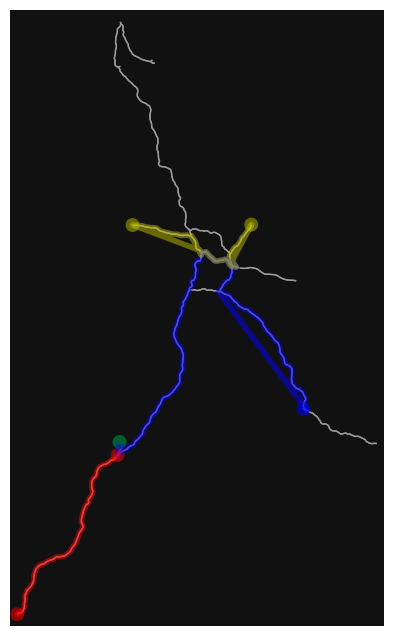

True shortest paths


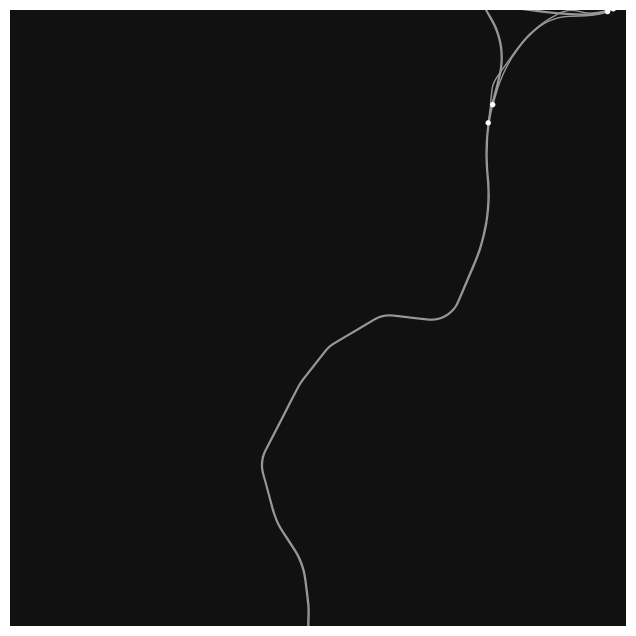

In [75]:
# calculate shortest paths for the 2 routes
route1 = nx.shortest_path(graph, orig1, dest1, weight='length')
route2 = nx.shortest_path(graph, orig2, dest2, weight='length')
route3 = nx.shortest_path(graph, orig3, dest3, weight='length')
route4 = nx.shortest_path(graph, orig4, dest4, weight='length')

routes = [route1, route2, route3, route4]
rc = ['b', 'y', 'g', 'r']
fig, ax = ox.plot_graph_routes(graph, routes, route_colors=rc, route_linewidth=6, node_size=0)
print("True shortest paths")

pt = ox.graph_to_gdfs(graph, edges=False).unary_union.centroid
bbox = ox.utils_geo.bbox_from_point((pt.y, pt.x), dist=5000)
fig, ax = ox.plot_graph_routes(graph, [route4, route4], ['r', 'r'], bbox=bbox)

start
funky 2!
11463069026
[11463069026]
[11463069026, 6670536027, 2462644833, 2462644906]
start
start
funky 1!
(1009, 368)
89967333
[89967333]
[89967333, 7119817058]
funky 2!
89908977
[89908977]
[89908977, 89891353]
start
Same path!


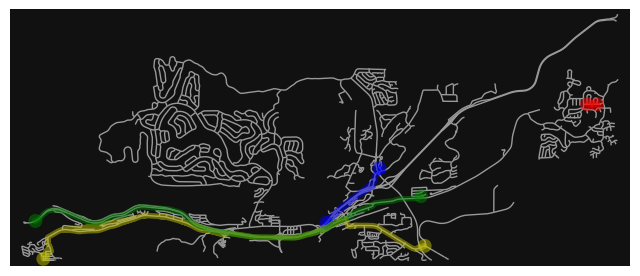

Simulator shortest paths


In [244]:
calcr1 = calculatePath(matrix, distance_matrix, orig1, dest1, translations, inverted_translations)
calcr2 = calculatePath(matrix, distance_matrix, orig2, dest2, translations, inverted_translations)
calcr3 = calculatePath(matrix, distance_matrix, orig3, dest3, translations, inverted_translations)
calcr4 = calculatePath(matrix, distance_matrix, orig4, dest4, translations, inverted_translations)

fig, ax = ox.plot_graph_routes(graph, [calcr1, calcr2, calcr3, calcr4], route_colors=rc, route_linewidth=6, node_size=0)
print("Simulator shortest paths")

In [245]:
print("Do they agree on path 1? " + "Yes!" if calcr1 == route1 else f"No: \n{calcr1} \n{route1}")
print("Do they agree on path 2? " + "Yes!" if calcr2 == route2 else f"No: \n{calcr2} \n{route2}")
print("Do they agree on path 3? " + "Yes!" if calcr3 == route3 else f"No: \n{calcr3} \n{route3}")
print("Do they agree on path 4? " + "Yes!" if calcr4 == route4 else f"No: \n{calcr4} \n{route4}")

Do they agree on path 1? Yes!
Do they agree on path 2? Yes!
Do they agree on path 3? Yes!
Do they agree on path 4? Yes!
